## Пункт 1. Определяем декоратор подсчета вызовов функции

In [212]:
import numpy as np
import matplotlib.pyplot as plt
import random
import copy
import pandas as pd
import seaborn as sns
import math
import multiprocessing 

## Пока предполагаем, что функция потерь работает с моделью линейной регрессии. 

In [213]:
def count_calls(func):
    def wrapper(*args, **kwargs):
        wrapper.calls += 1
        return func(*args, **kwargs)

    wrapper.calls = 0
    return wrapper

        
class LossFunction:
    pass


class MSE(LossFunction):

    @staticmethod
    @count_calls
    def grad_w(batch_elem, w, b):
        """
        :param batch_elem: batch_elem[i][0] = x_i, batch_elem[i][1] = y_real
        :param w: [w_1, w_2, ..., w_n] - parameters of the model
        :param b: additional constant for the model
        :return: gradient of the loss MSE function in point 'w'
        """
        grad_w = sum(
            (batch_elem[i][1] - np.transpose(w) @ np.transpose(batch_elem[i][0]) - b) * (-batch_elem[i][0])
            for i in range(len(batch_elem))
        )
        grad_w = 2 * grad_w / len(batch_elem)
        return np.transpose(np.clip(grad_w, -1e2, 1e2))

    @staticmethod
    @count_calls
    def grad_b(batch_elem, w, b):
        grad_b = sum(
            (batch_elem[i][1] - np.transpose(w) @ np.transpose(batch_elem[i][0]) - b) * (-1)
            for i in range(len(batch_elem))
        )
        grad_b = 2 * grad_b / len(batch_elem)
        return np.transpose(np.clip(grad_b, -1e2, 1e2))
   

## Определим разные типы шага обучения

In [214]:
class LearningRate:
    def __init__(self, init_lr):
        self.init_lr = init_lr

    def learning_rate(self, ep, it):
        pass


class ConstantLearningRate(LearningRate):
    def learning_rate(self, ep, it):
        return self.init_lr


class ExponentialLearningRate(LearningRate):
    def __init__(self, init_lr, k):
        super().__init__(init_lr)
        self.k = k
        
    def learning_rate(self, ep, it):
        return self.init_lr * math.exp(-self.k*it)


class StepLearningRate(LearningRate):
    def __init__(self, init_lr, drop=0.5, epochs_drop=10):
        super().__init__(init_lr)
        self.init_lr = init_lr
        self.drop = drop
        self.epochs_drop = epochs_drop
        self.lrate = init_lr
        self.was = set()
        
    def learning_rate(self, epoch, it):
        if epoch % self.epochs_drop == 0 and epoch not in self.was:
            self.lrate = self.init_lr * math.pow(self.drop,
                                                 math.floor((1 + epoch) / self.epochs_drop))
            self.was.add(epoch)
        return self.lrate

## Будем генерировать данные как рандомный набор $X$ и набор $Y$, который примерно будет похож на зависимость $Y = 2X + 1$. Чтобы точки были хоть сколько-то разбросаны, добавим гауссова шума.

In [215]:
N = 1000
X = np.random.uniform(low=1, high=50, size=N)
Y = 2 * X + 1 + 2 * np.random.normal(scale=10, size=N)

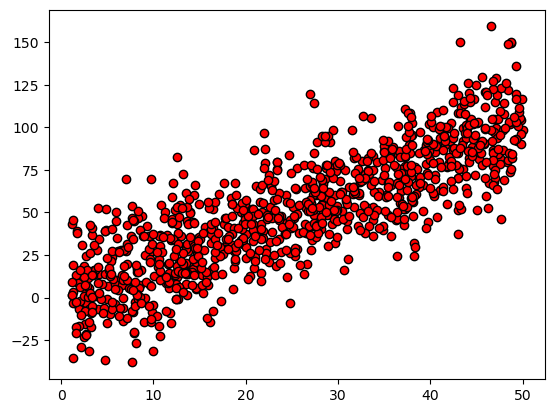

In [216]:
plt.scatter(X, Y, edgecolors='black', color="red")
plt.show()

## Выберем такое такие точки $x$ и $y$, чтоб их распределение было удобным для аппрокимации прямой путем SGD

In [217]:
def sgd(x_dots, y_dots, dimension, loss_func, lr=LearningRate(0.001), epoch=50, batch_size=128):
    """
    x_dots - features
    y_dots - real y values
    dimension - is the dimension of every point from x
    iterations - number of iterations
    lr - is the coeff before stochastic gradient
    batch_size - number of points to take from x_dots
    """
    w = np.random.rand(dimension, 1)
    b = 0.5
    x_training = copy.copy(x_dots)
    it = 1
    for ep in range(epoch):
        while len(x_training) != 0:
            rand_indexes = [i for i in range(len(x_training))] if len(x_training) < batch_size else random.sample(range(len(x_training)), batch_size)
            batch_elem = [(np.matrix(x_dots[i]), y_dots[i]) for i in rand_indexes]
            w = w - lr.learning_rate(ep, it) * loss_func.grad_w(batch_elem, w, b)
            b = b - lr.learning_rate(ep, it) * loss_func.grad_b(batch_elem, w, b)
            x_training = np.delete(x_training, rand_indexes, axis=0)
            it += 1
        x_training = copy.copy(x_dots)
    return w, b

 ## Случай одномерных данных, решим задачу определения коэффициентов аппроксиммируемой прямой. Размер батча 128.

1.9056596890553883 0.7658386388518694


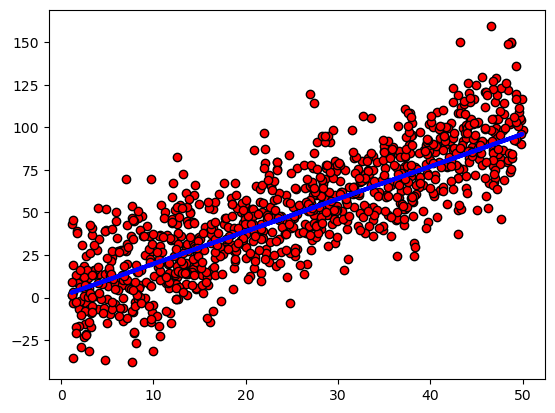

   Function Calls
0              20


In [218]:
w, b = sgd(X, Y, 1, MSE, lr = ConstantLearningRate(0.001), epoch=2, batch_size=100)
Y_predicted = w[0, 0] * X + b[0, 0]
print(w[0, 0], b[0, 0])
plt.scatter(X, Y, edgecolors='black', color="red")
plt.plot(X, Y_predicted, color='blue', linewidth=3)
plt.show()
tbl = {'Function Calls' : [MSE.grad_w.calls]}
print(pd.DataFrame(tbl))

## Как видим, SGD достаточно хорошо справляется с задачей нахождения параметров модели линейной регрессии. Прямая очень точно приближает среднее значение выборки. 

## Попробуем поиграться с размером батча. Пусть размер батча теперь равен N.

In [219]:
import IPython.display
MSE.grad_w.calls = 0
w, b = sgd(X, Y, 1, MSE, lr = ConstantLearningRate(0.001), epoch=50, batch_size=N)
tbl = {'Function Calls' : [MSE.grad_w.calls]}
display(pd.DataFrame(tbl))
print((w, b))

,Function Calls
0,50


(matrix([[1.97557765]]), matrix([[1.30472342]]))


## Теперь размер батча теперь равен 1.

In [220]:
MSE.grad_w.calls = 0
w, b = sgd(X, Y, 1, MSE, lr = ConstantLearningRate(0.001), epoch=3, batch_size=1)
tbl = {'Function Calls' : [MSE.grad_w.calls]}
display(pd.DataFrame(tbl))
print((w, b))

,Function Calls
0,3000


(matrix([[1.92443124]]), matrix([[1.60549794]]))


## А теперь размер батча равен 256.

In [221]:
MSE.grad_w.calls = 0
w, b = sgd(X, Y, 1, MSE, lr = ConstantLearningRate(0.001), epoch=3, batch_size=256)
tbl = {'Function Calls' : [MSE.grad_w.calls]}
display(pd.DataFrame(tbl))
print((w, b))

,Function Calls
0,12


(matrix([[1.99643132]]), matrix([[0.81821296]]))


## Теперь перейдем к многомерным данным. Будем строить модель для предсказания цены дома, в зависимости от различных параметров.

# Dataset : California Housing Prices
## https://www.kaggle.com/datasets/camnugent/california-housing-prices

In [222]:
data = pd.read_csv("housing.csv")

In [223]:
data

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY
...,...,...,...,...,...,...,...,...,...,...
20635,-121.09,39.48,25.0,1665.0,374.0,845.0,330.0,1.5603,78100.0,INLAND
20636,-121.21,39.49,18.0,697.0,150.0,356.0,114.0,2.5568,77100.0,INLAND
20637,-121.22,39.43,17.0,2254.0,485.0,1007.0,433.0,1.7000,92300.0,INLAND
20638,-121.32,39.43,18.0,1860.0,409.0,741.0,349.0,1.8672,84700.0,INLAND


# Data preprocessing

In [224]:
def data_preprocessing(X_features, Y_values):
    data_preproc = X_features.join(Y_values)
    data_preproc = data_preproc.join(pd.get_dummies(data_preproc.ocean_proximity)).drop(['ocean_proximity'], axis=1)
    X_prep, Y_prep = data_preproc.drop(['median_house_value'], axis=1), data_preproc['median_house_value']
    return X_prep.to_numpy(), Y_prep.to_numpy().flatten()

## Будем обучать модель на тренировочных данных, а потом проверять, насколько хорошо модель работает с тестовыми данными.

In [225]:
from sklearn.model_selection import train_test_split
data.dropna(inplace=True)
X = data.drop(['median_house_value'], axis=1)
Y = data['median_house_value']
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)
X_table = copy.copy(X_test)
Y_table = copy.copy(Y_test)

In [226]:
X_train, Y_train = data_preprocessing(X_train, Y_train)
X_test, Y_test = data_preprocessing(X_test, Y_test)

In [227]:
MSE.grad_w.calls = 0
w, b = sgd(X_train, Y_train, len(X_train[0]), MSE, lr = ConstantLearningRate(0.001), epoch=50, batch_size=128)
w = np.squeeze(np.asarray(w))
b = b.item(0)
tbl = {'Function Calls' : [MSE.grad_w.calls]}
print(pd.DataFrame(tbl))

   Function Calls
0            6400


In [228]:
for i in range(len(X_test)):
    if X_test[i].shape != w.shape:
        X_test[i] = np.append(X_test[i], False)
Y_predicted = [(np.dot(w, X_test[i])) + b for i in range(len(X_test))]
print(sum([(Y_train[i] -  Y_predicted[i]) ** 2 for i in range(len(Y_test))]))

69134716213927.234


In [229]:
prediction_table = pd.DataFrame(Y_predicted, columns=['predicted_Cost'])

In [230]:
table = X_table.join(Y_table)
table = table.join(prediction_table)
table.dropna(inplace=True)
table

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,median_house_value,predicted_Cost
1600,-122.12,37.89,30.0,3227.0,733.0,1260.0,684.0,4.1250,NEAR BAY,257100.0,118431.994135
3601,-118.49,34.23,32.0,4373.0,683.0,2040.0,693.0,5.2668,<1H OCEAN,242300.0,174843.277555
1741,-122.33,37.96,46.0,1222.0,236.0,819.0,251.0,3.9118,NEAR BAY,129400.0,113101.687341
1566,-121.96,37.74,2.0,200.0,20.0,25.0,9.0,15.0001,<1H OCEAN,350000.0,172509.569597
3085,-118.50,35.70,18.0,3303.0,814.0,986.0,522.0,1.5957,INLAND,101400.0,209105.476097
...,...,...,...,...,...,...,...,...,...,...,...
370,-122.15,37.75,44.0,1938.0,399.0,946.0,331.0,3.2250,NEAR BAY,135800.0,130849.123286
3380,-118.27,34.25,35.0,2091.0,360.0,879.0,326.0,4.4485,<1H OCEAN,261900.0,162085.027344
215,-122.22,37.79,38.0,3049.0,711.0,2167.0,659.0,2.7969,NEAR BAY,141700.0,162070.671381
3666,-118.38,34.24,38.0,125.0,42.0,63.0,29.0,1.3594,<1H OCEAN,158300.0,126220.667265


# Пункт 2. Learning rate scheduling.

## Экспоненциальный шаг обучения

1.9768613462644045 0.790200082493264


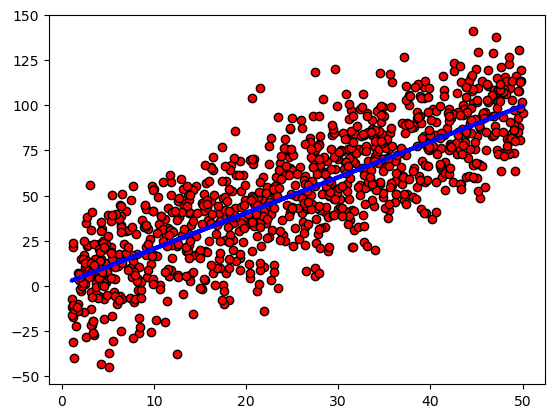

   Function Calls
0              40


In [231]:
MSE.grad_w.calls = 0
X = np.random.uniform(low=1, high=50, size=N)
Y = 2 * X + 1 + 2 * np.random.normal(scale=10, size=N)
w, b = sgd(X, Y, 1, MSE, lr = ExponentialLearningRate(0.001, 0.01), epoch=4, batch_size=100)
Y_predicted = w[0, 0] * X + b[0, 0]
print(w[0, 0], b[0, 0])
plt.scatter(X, Y, edgecolors='black', color="red")
plt.plot(X, Y_predicted, color='blue', linewidth=3)
plt.show()
tbl = {'Function Calls' : [MSE.grad_w.calls]}
print(pd.DataFrame(tbl))

In [232]:
MSE.grad_w.calls = 0
sgd(X, Y, 1, MSE, lr = ExponentialLearningRate(0.001, 0.01), epoch=50, batch_size=N)
tbl = {'Function Calls' : [MSE.grad_w.calls]}
print(pd.DataFrame(tbl))

   Function Calls
0              50


In [233]:
MSE.grad_w.calls = 0
sgd(X, Y, 1, MSE, lr = ExponentialLearningRate(0.001, 0.01), epoch=3, batch_size=1)
tbl = {'Function Calls' : [MSE.grad_w.calls]}
print(pd.DataFrame(tbl))

   Function Calls
0            3000


In [234]:
MSE.grad_w.calls = 0
sgd(X, Y, 1, MSE, lr = ExponentialLearningRate(0.001, 0.01), epoch=5, batch_size=256)
tbl = {'Function Calls' : [MSE.grad_w.calls]}
print(pd.DataFrame(tbl))

   Function Calls
0              20


In [235]:
MSE.grad_w.calls = 0
w, b = sgd(X_train, Y_train, len(X_train[0]), MSE, lr = ExponentialLearningRate(0.001, 0.01), epoch=50, batch_size=128)
w = np.squeeze(np.asarray(w))
b = b.item(0)
Y_predicted = [(np.dot(w, X_test[i])) + b for i in range(len(X_test))]
prediction_table = pd.DataFrame(Y_predicted, columns=['predicted_Cost'])
table = X_table.join(Y_table)
table = table.join(prediction_table)
table.dropna(inplace=True)
table
tbl = {'Function Calls' : [MSE.grad_w.calls]}
print(pd.DataFrame(tbl))

   Function Calls
0            6400


## Ошибка

In [236]:
print(sum([(Y_train[i] -  Y_predicted[i]) ** 2 for i in range(len(Y_test))]))

150651512266621.38


## Ступенчатый шаг обучения

2.0376845844139924 0.8498237024167717


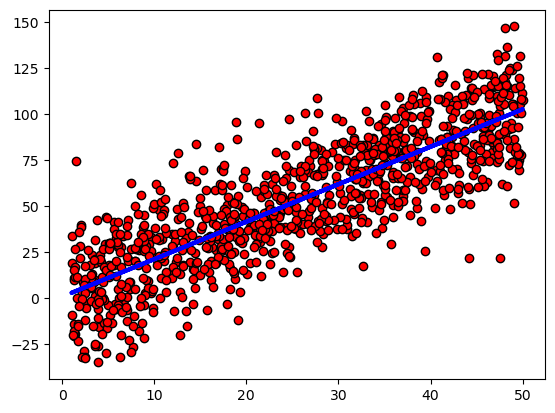

   Function Calls
0              50


In [237]:
MSE.grad_w.calls = 0
X = np.random.uniform(low=1, high=50, size=N)
Y = 2 * X + 1 + 2 * np.random.normal(scale=10, size=N)
w, b = sgd(X, Y, 1, MSE, lr = StepLearningRate(0.01, drop=0.5, epochs_drop=1), epoch=5, batch_size=100)
Y_predicted = w[0, 0] * X + b[0, 0]
print(w[0, 0], b[0, 0])
plt.scatter(X, Y, edgecolors='black', color="red")
plt.plot(X, Y_predicted, color='blue', linewidth=3)
plt.show()
tbl = {'Function Calls' : [MSE.grad_w.calls]}
print(pd.DataFrame(tbl))

In [238]:
sgd(X, Y, 1, MSE, lr = StepLearningRate(0.001), epoch=50, batch_size=N)

(matrix([[2.0244283]]), matrix([[1.17892095]]))

In [239]:
sgd(X, Y, 1, MSE, lr = StepLearningRate(0.001, drop=0.2, epochs_drop=1), epoch=3, batch_size=1)

(matrix([[2.0221711]]), matrix([[1.43857901]]))

In [240]:
sgd(X, Y, 1, MSE, lr = StepLearningRate(0.01, drop=0.5, epochs_drop=1), epoch=5, batch_size=256)

(matrix([[2.04077383]]), matrix([[0.81658242]]))

In [241]:
w, b = sgd(X_train, Y_train, len(X_train[0]), MSE, lr = StepLearningRate(0.001), epoch=50, batch_size=128)
w = np.squeeze(np.asarray(w))
b = b.item(0)
Y_predicted = [(np.dot(w, X_test[i])) + b for i in range(len(X_test))]
print(sum([(Y_train[i] -  Y_predicted[i]) ** 2 for i in range(len(Y_test))]))
prediction_table = pd.DataFrame(Y_predicted, columns=['predicted_Cost'])
table = X_table.join(Y_table)
table = table.join(prediction_table)
table.dropna(inplace=True)
table

93355284229177.73


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,median_house_value,predicted_Cost
1600,-122.12,37.89,30.0,3227.0,733.0,1260.0,684.0,4.1250,NEAR BAY,257100.0,86244.046545
3601,-118.49,34.23,32.0,4373.0,683.0,2040.0,693.0,5.2668,<1H OCEAN,242300.0,133296.220346
1741,-122.33,37.96,46.0,1222.0,236.0,819.0,251.0,3.9118,NEAR BAY,129400.0,54727.238714
1566,-121.96,37.74,2.0,200.0,20.0,25.0,9.0,15.0001,<1H OCEAN,350000.0,126664.345433
3085,-118.50,35.70,18.0,3303.0,814.0,986.0,522.0,1.5957,INLAND,101400.0,159100.322189
...,...,...,...,...,...,...,...,...,...,...,...
370,-122.15,37.75,44.0,1938.0,399.0,946.0,331.0,3.2250,NEAR BAY,135800.0,104365.073204
3380,-118.27,34.25,35.0,2091.0,360.0,879.0,326.0,4.4485,<1H OCEAN,261900.0,118933.928214
215,-122.22,37.79,38.0,3049.0,711.0,2167.0,659.0,2.7969,NEAR BAY,141700.0,84511.290039
3666,-118.38,34.24,38.0,125.0,42.0,63.0,29.0,1.3594,<1H OCEAN,158300.0,59632.803247


## Ошибка

In [242]:
print(sum([(Y_train[i] -  Y_predicted[i]) ** 2 for i in range(len(Y_test))]))

93355284229177.73


## Перейдем к полиномиальной регрессии.

In [258]:
import torch
df = pd.read_csv('CarPrice_Assignment.csv')
df

,car_ID,symboling,CarName,fueltype,aspiration,doornumber,carbody,drivewheel,enginelocation,wheelbase,...,enginesize,fuelsystem,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg,price
0,1,3,alfa-romero giulia,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,13495.0
1,2,3,alfa-romero stelvio,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,16500.0
2,3,1,alfa-romero Quadrifoglio,gas,std,two,hatchback,rwd,front,94.5,...,152,mpfi,2.68,3.47,9.0,154,5000,19,26,16500.0
3,4,2,audi 100 ls,gas,std,four,sedan,fwd,front,99.8,...,109,mpfi,3.19,3.40,10.0,102,5500,24,30,13950.0
4,5,2,audi 100ls,gas,std,four,sedan,4wd,front,99.4,...,136,mpfi,3.19,3.40,8.0,115,5500,18,22,17450.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
200,201,-1,volvo 145e (sw),gas,std,four,sedan,rwd,front,109.1,...,141,mpfi,3.78,3.15,9.5,114,5400,23,28,16845.0
201,202,-1,volvo 144ea,gas,turbo,four,sedan,rwd,front,109.1,...,141,mpfi,3.78,3.15,8.7,160,5300,19,25,19045.0
202,203,-1,volvo 244dl,gas,std,four,sedan,rwd,front,109.1,...,173,mpfi,3.58,2.87,8.8,134,5500,18,23,21485.0
203,204,-1,volvo 246,diesel,turbo,four,sedan,rwd,front,109.1,...,145,idi,3.01,3.40,23.0,106,4800,26,27,22470.0


In [259]:
df = df[['wheelbase', 'enginesize', 'carlength', 'carwidth', 'carheight', 'curbweight', 'boreratio', 'stroke', 'compressionratio', 'horsepower', 'peakrpm', 'citympg',  'highwaympg', 'price']]

In [260]:
def plotter(column_list, target_col, df):
    """Plots scatterplot for each independent variable against the target variable
    
    Args-
        column_list- List containing names of all the dependent variables
        target_col- Name of the target variable
        df- The dataframe
    Returns-
        None
    """
    independent_vars_number = len(column_list)
    color = ['b', 'g', 'r', 'c', 'm', 'y', 'k']
    fig, axes = plt.subplots(independent_vars_number, figsize = (5, 5 * independent_vars_number))
    for col, ax in zip(column_list, axes):
        ax.scatter(df[col], df[target_col], alpha = 0.3, c = np.random.choice(color))
        ax.set_xlabel(col)
        ax.set_ylabel(target_col)

<Axes: title={'center': 'Correlation HeatMap'}>

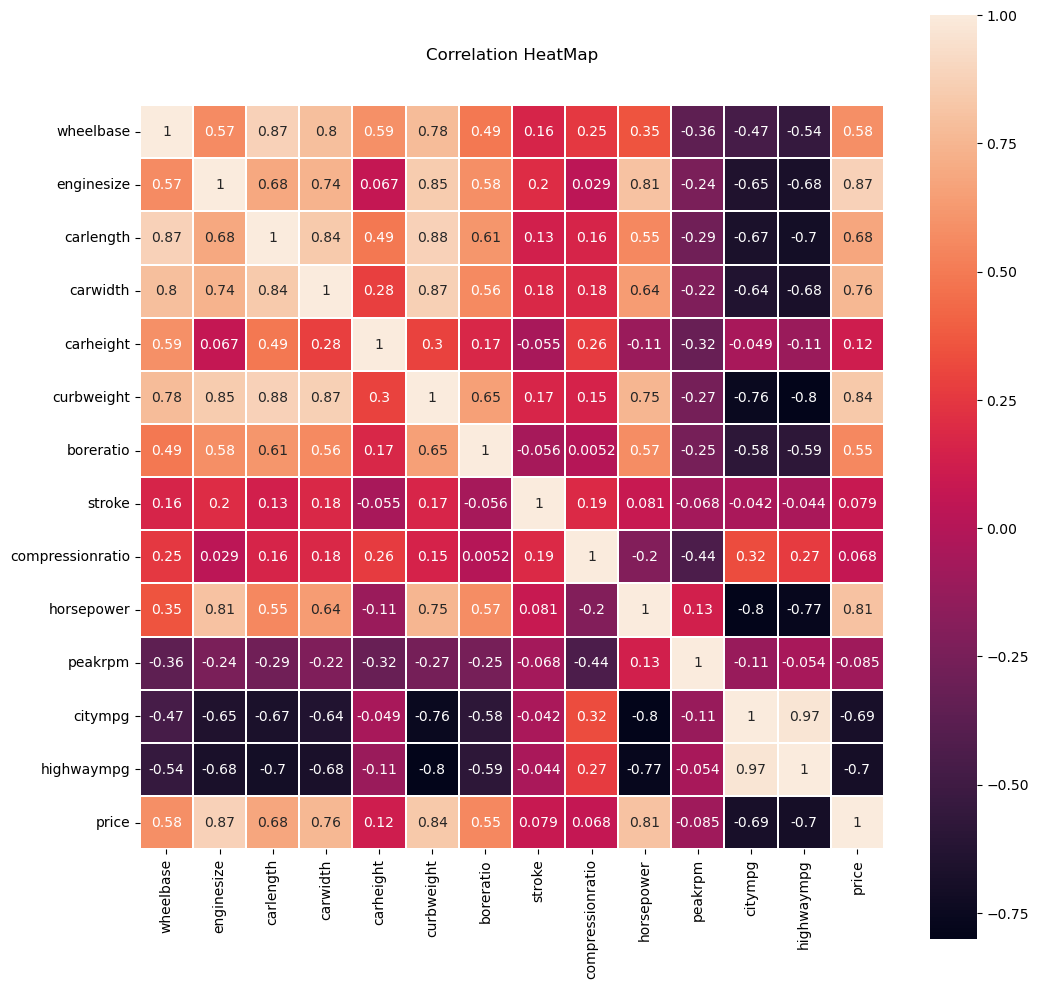

In [261]:
plt.figure(figsize=(12,12))
plt.title('Correlation HeatMap', y = 1.05)
sns.heatmap(df.corr(),linewidths=0.1,vmax=1.0, square=True, linecolor='white', annot=True)

## Заметим, что enginesize, curbweight, horsepower, carwidth, citympg, highwaympg, carlength имеют достаточно сильную корелляцию.

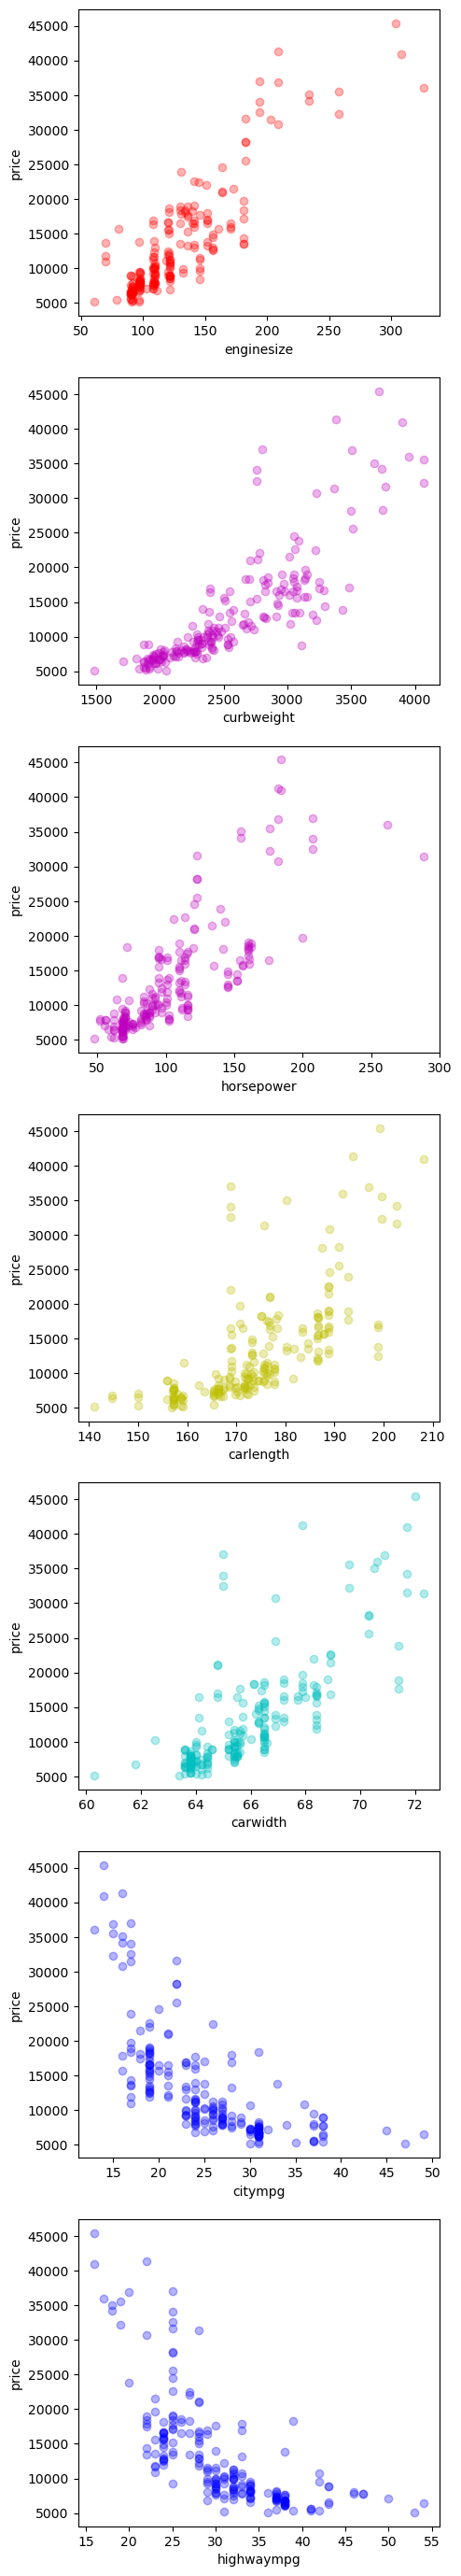

In [262]:
df = df[['enginesize', 'curbweight','horsepower', 'carlength', 'carwidth', 'citympg', 'highwaympg', 'price']].astype('float64')
features = df[['enginesize', 'curbweight','horsepower', 'carlength', 'carwidth', 'citympg', 'highwaympg']]
target = df['price']
cols = list(features.columns)
target_col = 'price'
plotter(cols, target_col, df)

## Исходя из графика предположим, что cubweight, horsepower, carlength, carwidth имеют квадратичную зависимость, то есть $y = w_{2}x^2 + w_{1}x + b$, а citympg и highwaympg имеют обратную квадратичную зависимость $y = \frac{w_{0}}{x} + \frac{w_{1}}{x^2} + b$. 

In [263]:
features_quad = features[['enginesize', 'curbweight', 'horsepower', 'carlength', 'carwidth']].to_numpy() # converting DF to numpy array
features_quad = torch.from_numpy(features_quad)
features_inversed_quad = features[['citympg', 'highwaympg']].to_numpy()
features_inversed_quad = torch.from_numpy(features_inversed_quad)
print(features_quad)

tensor([[ 130.0000, 2548.0000,  111.0000,  168.8000,   64.1000],
        [ 130.0000, 2548.0000,  111.0000,  168.8000,   64.1000],
        [ 152.0000, 2823.0000,  154.0000,  171.2000,   65.5000],
        ...,
        [ 173.0000, 3012.0000,  134.0000,  188.8000,   68.9000],
        [ 145.0000, 3217.0000,  106.0000,  188.8000,   68.9000],
        [ 141.0000, 3062.0000,  114.0000,  188.8000,   68.9000]],
       dtype=torch.float64)


## Мы можем представлять данные пользуясь линейной регрессией. В первом случае скажем, что $z_{0} = x, z_{1} = x^2$, а во втором $z_{0} = \frac{1}{x}, z_{1} = \frac{1}{x^2}$. Тогда наша модель будет иметь привычный вид : $y = w_{0}z_{0} + w_{1}z_{1} + b$

In [264]:
features_quad = torch.cat((features_quad, features_quad * features_quad), dim=1)
features_inversed_quad = 1 / features_inversed_quad
features_inversed_quad = torch.cat((features_inversed_quad, features_inversed_quad * features_inversed_quad), dim=1)
combined_features = torch.cat((features_quad, features_inversed_quad), dim=1)

In [265]:
def minMaxNormalizer(feature_tensor): 
    total_cols = feature_tensor.size()[1] # total unmber of columns 
    for i in range(total_cols): # iterating through each column
        feature_col = feature_tensor[:, i]
        maximum = torch.max(feature_col) # maximum stores max value of the column
        minimum = torch.min(feature_col) # minimum stores min value of the column
        feature_tensor[:, i] = (feature_tensor[:, i] - minimum) / (maximum - minimum) # min-max scalinng of each element of the column


In [266]:
minMaxNormalizer(combined_features)
w = torch.rand(combined_features.size()[1], requires_grad = True)

In [267]:
b = torch.rand(1, requires_grad = True)
target = torch.from_numpy(target.to_numpy())
def polyRegression(features, weights, bias):
    y_hat = (weights.float() @ features.t().float()) + bias.float()
    return y_hat

In [268]:
class Regularization:
    def __init__(self, lamb):
        self.lamb = lamb
class L1(Regularization):
    def get(self, weights):
        absolute_sum = torch.abs(weights).sum()
        return self.lamb * absolute_sum.item()
class L2(Regularization):
    def get(self, weights):
        squared_sum = torch.sum(weights ** 2)
        return self.lamb * squared_sum.item()
class Elastic(Regularization):
    def __init__(self, lamb, percentage):
        super().__init__(lamb)
        self.percentage = percentage
        self.l1 = L1(lamb)
        self.l2 = L2(lamb)
    def get(self, weights):
        return self.percentage/100 * self.l1.get(weights) + (1-self.percentage/100) * self.l2.get(weights)

In [269]:
@count_calls
def meanSqrError(y, y_hat, weights, regularization):
    return torch.sum((y - y_hat) ** 2) / torch.numel(y) + regularization.get(weights) 

In [270]:
def stochGradDesPoly(learning_rate, epochs, target, features, weights, bias, reg):
    MSE_list = torch.empty(0)
    for i in range(epochs):
        predictions = polyRegression(features, weights, bias)
        MSE = meanSqrError(target, predictions, weights, reg)
        MSE.backward()
        with torch.no_grad():
            weights -= weights.grad * learning_rate
            bias -= bias.grad * learning_rate
            weights.grad.zero_()
            bias.grad.zero_()
        MSE_list = torch.cat((MSE_list, MSE.reshape(1).float()), dim = 0)        
    return_dict = {'weights': weights, 'bias': bias, 'MSE_list': MSE_list}
    return return_dict

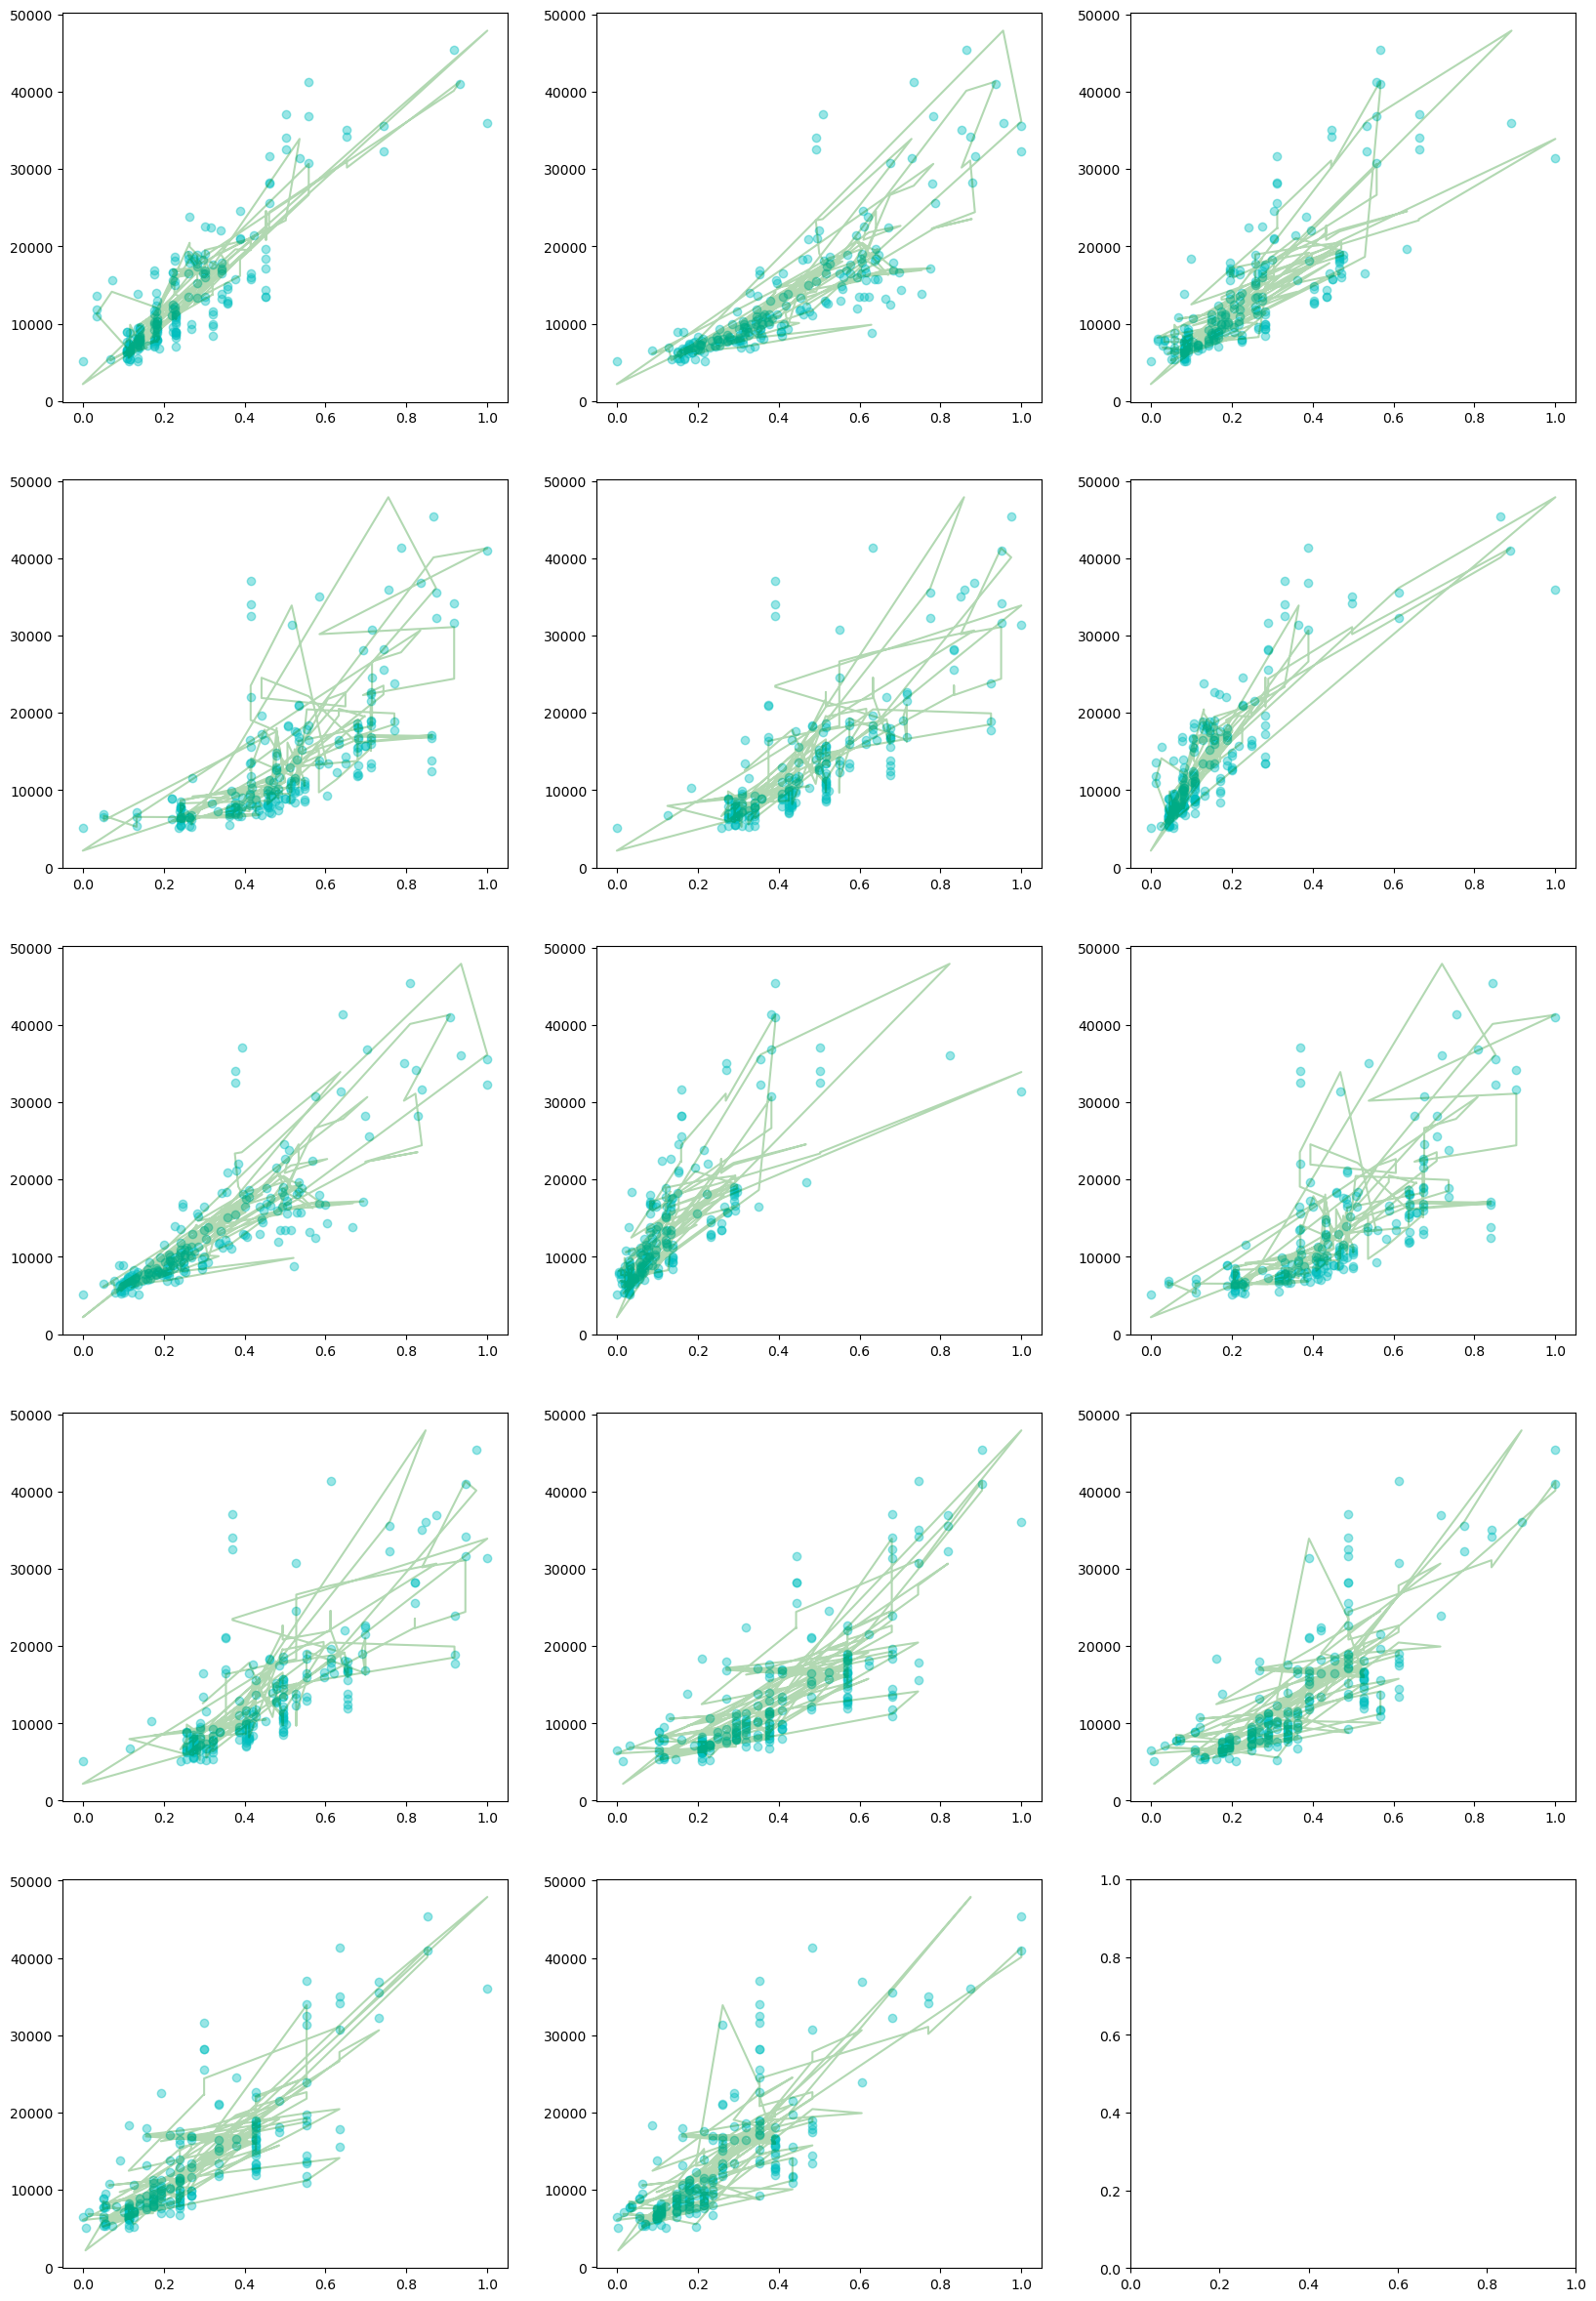

In [271]:
optimizer = stochGradDesPoly(0.1, 10000, target, combined_features, w, b, Elastic(0.1, 50))
pred = polyRegression(combined_features, optimizer['weights'], optimizer['bias'])
pred = pred.detach().numpy()
targets = target.numpy()
w = optimizer['weights'].detach().numpy()
fig, a = plt.subplots(5, 3, figsize = (20, 30))
it = 0
for i in range(0, 5):
    for j in range(0, 3):
        a[i, j].scatter(combined_features[:, it], target, color='c', alpha=0.4)
        a[i, j].plot(combined_features[:, it], pred, color='g', alpha=0.3)
        it+=1
        if it == len(combined_features[0]):
            break
    if it == len(combined_features[0]):
            break

In [272]:
tbl = {'Function calls' : [meanSqrError.calls]}
print(pd.DataFrame(tbl))

   Function calls
0           10000
